In [13]:
import pickle
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from typing import Callable, Optional
import einops
import matplotlib.pyplot as plt

import circuits.analysis as analysis
import circuits.eval_sae_as_classifier as eval_sae
import circuits.utils as utils
import circuits.f1_analysis as f1_analysis
import circuits.dictionary_learning.dictionary as dictionary
from circuits.dictionary_learning.dictionary import AutoEncoder
import circuits.chess_utils as chess_utils
import circuits.othello_utils as othello_utils


device = 'cuda:0'
device = 'cpu'

In [14]:
# load model
d_model = 512  # output dimension of the layer
layer = 6

othello = True

if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    model_type = "othello"

model = utils.get_model(model_name, device)

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cpu


In [15]:
# load SAE
# ae_path = '../autoencoders/chess_layer5_large_sweep/ef=16_lr=1e-03_l1=3e-02_layer_5'
# ae_path = '../autoencoders/chess_layer5_large_sweep/ef=4_lr=1e-03_l1=1e-01_layer_5'

ae_path = "../autoencoders/othello_mlp_acts_identity_aes/layer_3/indexing_None_n_inputs_100_feature_labels.pkl"

def get_feature_labels(autoencoder_path: str, high_threshold: float, filename_filter: str, device):

    results_filenames = analysis.get_all_results_file_names(autoencoder_path, filename_filter)
    if len(results_filenames) > 1 or len(results_filenames) == 0:
        raise ValueError("There are multiple results files")
    results_filename = results_filenames[0]

    with open(os.path.join(autoencoder_path, results_filename), 'rb') as f:
        results = pickle.load(f)
    results = utils.to_device(results, device)
    feature_labels, misc_stats = analysis.analyze_results_dict(results, "", device, high_threshold=high_threshold, save_results=False, print_results=False, verbose=False)
    return feature_labels


In [16]:

def plot_board(board_RR: torch.Tensor, title: str = "Board", png_filename: Optional[str] = None):
    """
    Plots an 8x8 board with the value of the maximum square displayed in red text to two decimal places.

    Args:
        board_RR (torch.Tensor): A 2D tensor of shape (8, 8) with values from 0 to 1.
        title (str): Title of the plot.
    """
    assert board_RR.shape == (8, 8), "board_RR must be of shape 8x8"

    # Flip the board vertically
    # board_RR = torch.flip(board_RR, [0])

    plt.imshow(board_RR, cmap='gray_r', interpolation='none')
    plt.colorbar()  # Adds a colorbar to help identify the values
    plt.title(title)

    # Set labels for columns (A-H)
    plt.xticks(range(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

    # Set labels for rows (1-8)
    plt.yticks(range(8), range(8, 0, -1))

    # Add gridlines mimicking a chess board
    # plt.grid(True, color='black', linewidth=1, linestyle='-', alpha=0.5)
    # plt.tick_params(bottom=False, left=False, labelbottom=True, labelleft=True)

    # Offset gridlines by 0.5 in x and y
    plt.gca().set_xticks([x - 0.5 for x in range(1, 9)], minor=True)
    plt.gca().set_yticks([y - 0.51 for y in range(1, 9)], minor=True)
    plt.grid(True, which='minor', color='black', linewidth=1, linestyle='-', alpha=0.5)

    # Find the maximum value and its position
    max_value, max_pos = torch.max(board_RR), torch.argmax(board_RR)
    max_i, max_j = torch.div(max_pos, 8, rounding_mode='floor'), max_pos % 8

    # Display the maximum value in red text at the corresponding position
    plt.text(max_j, max_i, f"{max_value:.0%}", color='red', ha='center', va='center', fontsize=12)

    # if png_filename is not None:
    #     plt.savefig(png_filename)

    plt.show()

In [17]:
def get_linear_probe_MDRRC(linear_probe_path: str) -> torch.Tensor:

    with open(linear_probe_path, "rb") as f:
        state_dict = torch.load(f, map_location=device)
        print(state_dict.keys())
        linear_probe_MDRRC = state_dict["linear_probe"]
    return linear_probe_MDRRC.squeeze()

def get_nanda_probe(nanda_probe_path: str) -> torch.Tensor:
    with open(nanda_probe_path, "rb") as f:
        state_dict = torch.load(f, map_location=device)
    print(state_dict.shape)


    full_linear_probe = state_dict

    rows = 8
    cols = 8 
    options = 3
    black_to_play_index = 0
    white_to_play_index = 1
    blank_index = 0
    their_index = 1
    my_index = 2
    linear_probe = torch.zeros(512, rows, cols, options, device=device)
    linear_probe[..., blank_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 0] + full_linear_probe[white_to_play_index, ..., 0])
    linear_probe[..., their_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 1] + full_linear_probe[white_to_play_index, ..., 2])
    linear_probe[..., my_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 2] + full_linear_probe[white_to_play_index, ..., 1])

    return linear_probe

torch.set_grad_enabled(False)
linear_probe_path = "../linear_probes/Othello-GPT-Transformer-Lens_othello_mine_yours_probe_layer_5.pth"
nanda_linear_probe_path = "../linear_probes/main_linear_probe.pth"

linear_probe_DRRC = get_nanda_probe(nanda_linear_probe_path)
linear_probe_DRRC = get_linear_probe_MDRRC(linear_probe_path)


torch.Size([3, 512, 8, 8, 3])
dict_keys(['linear_probe', 'final_loss', 'iters', 'epochs', 'acc', 'linear_probe_name', 'layer', 'indexing_function_name', 'batch_size', 'lr', 'wd', 'pos_start', 'num_epochs', 'num_games', 'modes', 'wandb_project', 'config_name', 'column_name', 'levels_of_interest', 'split', 'dataset_prefix', 'model_name', 'n_layers', 'wandb_run_name', 'player_color'])


torch.Size([2048, 512])
torch.Size([8, 8, 3])
torch.Size([8, 8, 3])


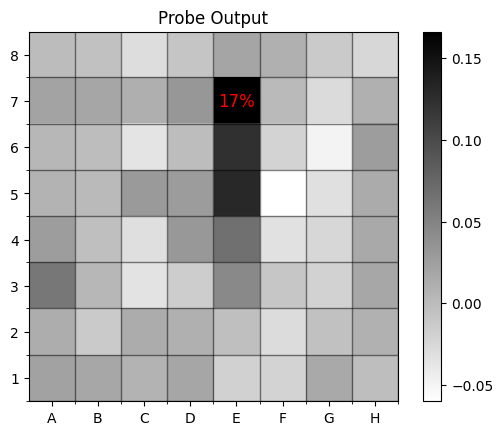

In [18]:
layer = 1
# print(model)
print(model.blocks[layer].mlp.W_out.shape)

neuron = 421
sample_vector_D = model.blocks[layer].mlp.W_out[neuron]

probe_out_RRC = einops.einsum(sample_vector_D, linear_probe_DRRC, "d, d r1 r2 c -> r1 r2 c").squeeze()
print(probe_out_RRC.shape)

sample_vector_D111 = einops.rearrange(sample_vector_D, "d -> d 1 1 1")

# Calculate dot product
# dot_product_RRC = torch.sum(sample_vector_D111 * linear_probe_DRRC, dim=0)

# # Calculate magnitude of linear probe vectors
# linear_probe_magnitude_RRC = torch.norm(linear_probe_DRRC, dim=0)

# # Calculate projection
# projection_RRC = dot_product_RRC / linear_probe_magnitude_RRC

# probe_out_RR = projection_RRC[..., 1]

cos_sim_RRC = F.cosine_similarity(sample_vector_D111, linear_probe_DRRC, dim=0)

print(cos_sim_RRC.shape)

probe_out_RR = cos_sim_RRC[..., 2]

# probe_out_RR = probe_out_RRC[..., 2]

plot_board(probe_out_RR, title="Probe Output", png_filename=None)

In [20]:
sample_vector_D.shape

linear_probe_DRRC.shape

torch.Size([512, 8, 8, 3])

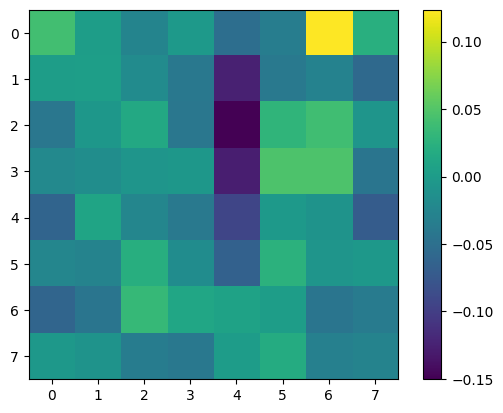

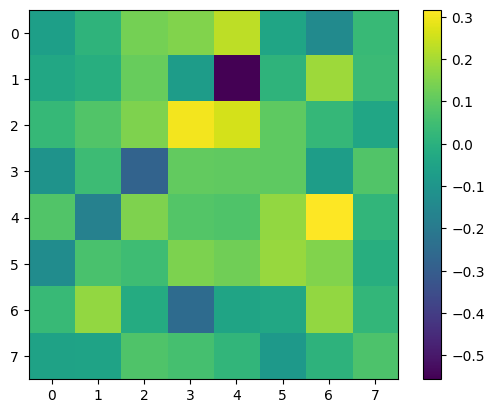

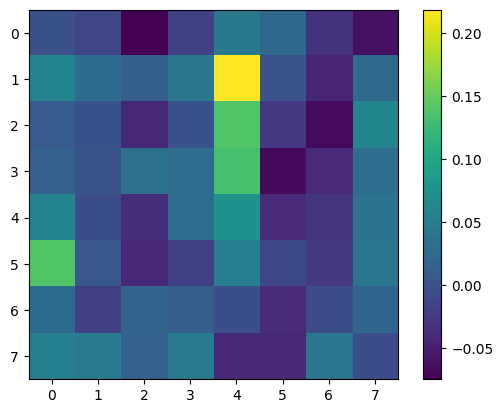

In [25]:
prod = sample_vector_D111 * linear_probe_DRRC
prod = prod.sum(0)

for i in range(3):
    plt.imshow(prod[..., i].cpu().numpy())
    plt.colorbar()
    plt.show()